In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [303]:
print(prices.columns)

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


In [305]:
prices = pd.read_csv('/Users/ainabukeyeva/Downloads/crypto_prices.csv')
news = pd.read_csv('/Users/ainabukeyeva/Downloads/crypto_news.csv')
prices['date'] = pd.to_datetime(prices['date'])
news['date'] = pd.to_datetime(news['date'])
prices.head()

date symbol    open    high     low   close       volume
0 2023-01-01    BTC  550.35  555.44  549.25  554.67  58708016.74
1 2023-01-02    BTC  552.78  553.05  544.50  544.89  12883086.91
2 2023-01-03    BTC  548.11  551.49  541.73  546.33  52958955.82
3 2023-01-04    BTC  545.34  552.11  540.60  548.04  57796910.14
4 2023-01-05    BTC  543.38  545.38  532.06  534.86  86701917.33

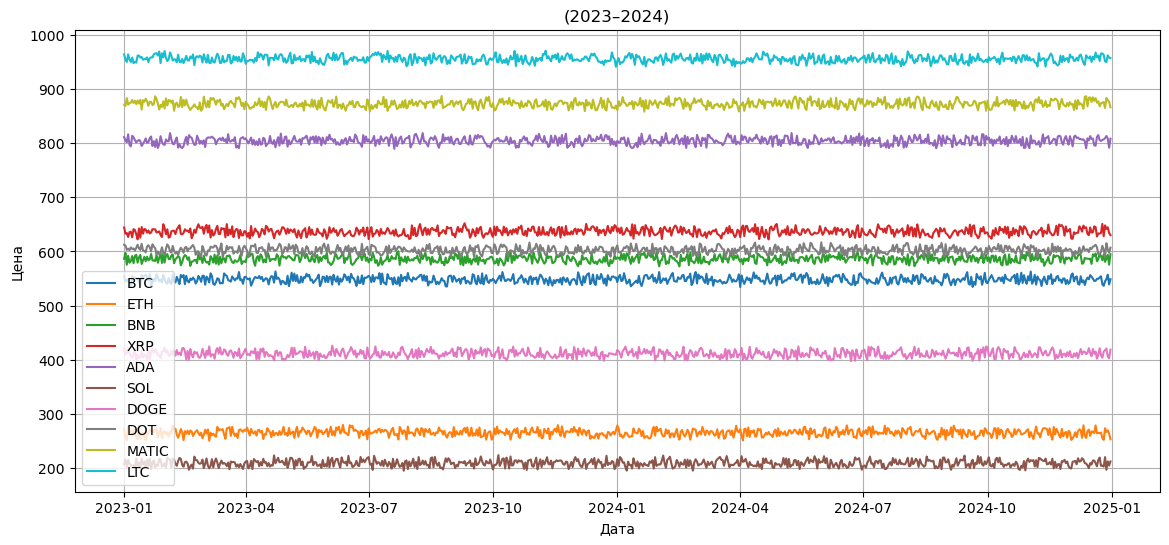

In [307]:
plt.figure(figsize=(14,6))
for sym in prices['symbol'].unique():
    subset = prices[prices['symbol'] == sym]
    plt.plot(subset['date'], subset['close'], label=sym)
plt.legend()
plt.title('(2023–2024)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

In [308]:
daily_news = news.groupby('date')['title'].apply(lambda x: ' '.join(x)).reset_index()
daily_news.head()

date                                              title
0 2023-01-01  Sample crypto news headline for ADA on 2023-01...
1 2023-01-02  Sample crypto news headline for LTC on 2023-01-02
2 2023-01-03  Sample crypto news headline for DOT on 2023-01...
3 2023-01-04  Sample crypto news headline for BTC on 2023-01-04
4 2023-01-05  Sample crypto news headline for SOL on 2023-01...

In [311]:
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(daily_news['title'])
svd = TruncatedSVD(n_components=1)
daily_news['sentiment_index'] = svd.fit_transform(X_tfidf)
daily_news.head()

date                                              title  \
0 2023-01-01  Sample crypto news headline for ADA on 2023-01...   
1 2023-01-02  Sample crypto news headline for LTC on 2023-01-02   
2 2023-01-03  Sample crypto news headline for DOT on 2023-01...   
3 2023-01-04  Sample crypto news headline for BTC on 2023-01-04   
4 2023-01-05  Sample crypto news headline for SOL on 2023-01...   

   sentiment_index  
0         0.459332  
1         0.551797  
2         0.582385  
3         0.551088  
4         0.595921

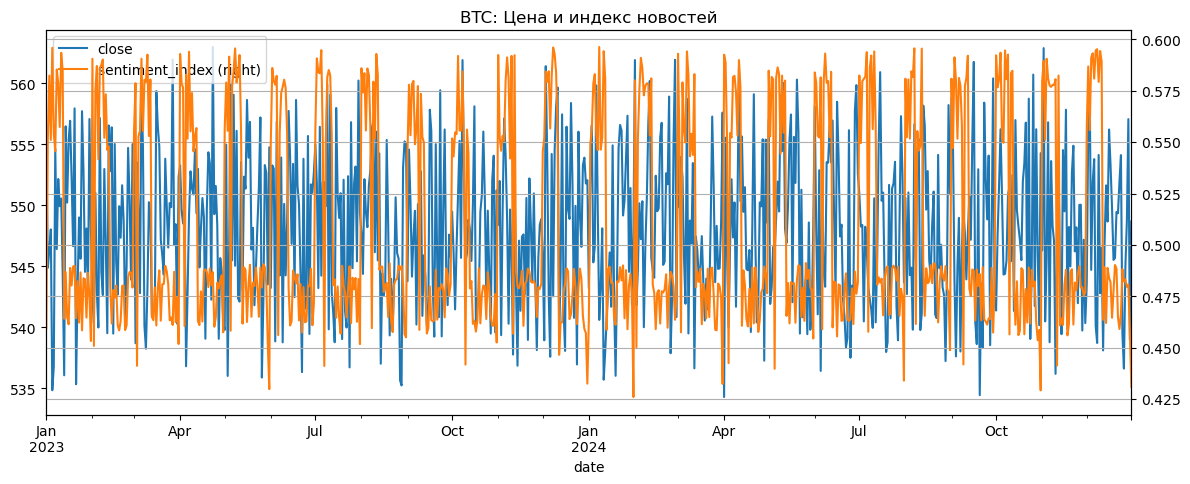

In [313]:
merged = prices[prices['symbol'] == 'BTC'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('BTC: Цена и индекс новостей')
plt.grid(True)
plt.show()

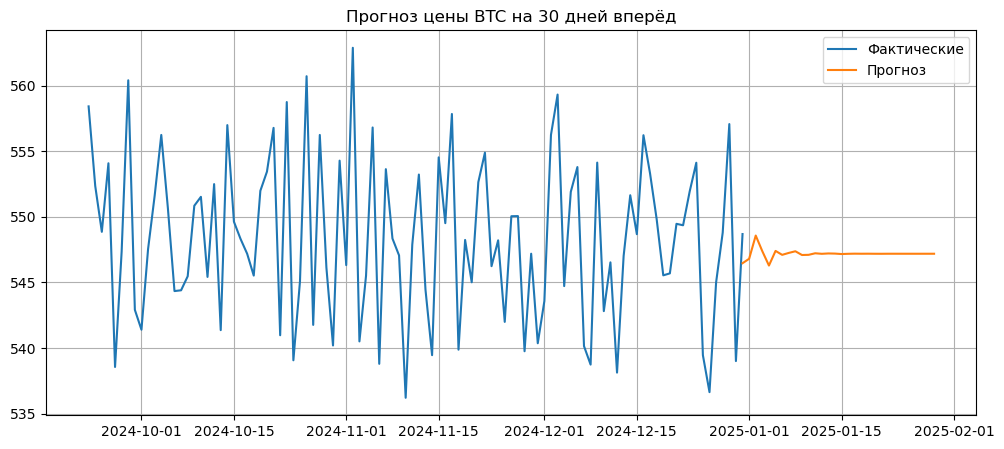

In [314]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз') 
plt.title('Прогноз цены BTC на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()

In [316]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'BTC'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.6362429556081235
R²: -0.4349493616726463

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150}
RMSE после тюнинга: 6.301302818302329
R² после тюнинга: 0.022902725362510257


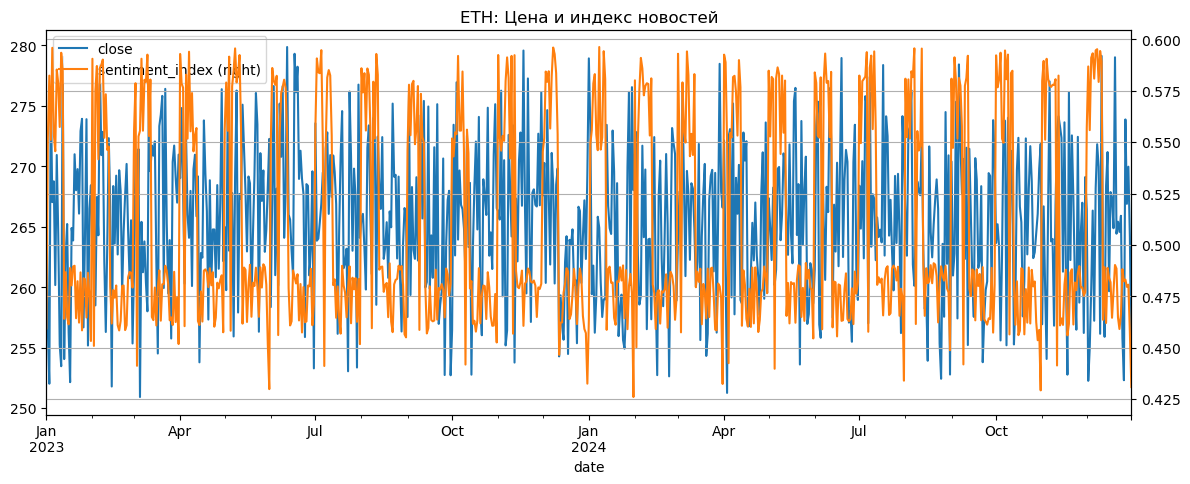

In [317]:
merged = prices[prices['symbol'] == 'ETH'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('ETH: Цена и индекс новостей')
plt.grid(True)
plt.show()

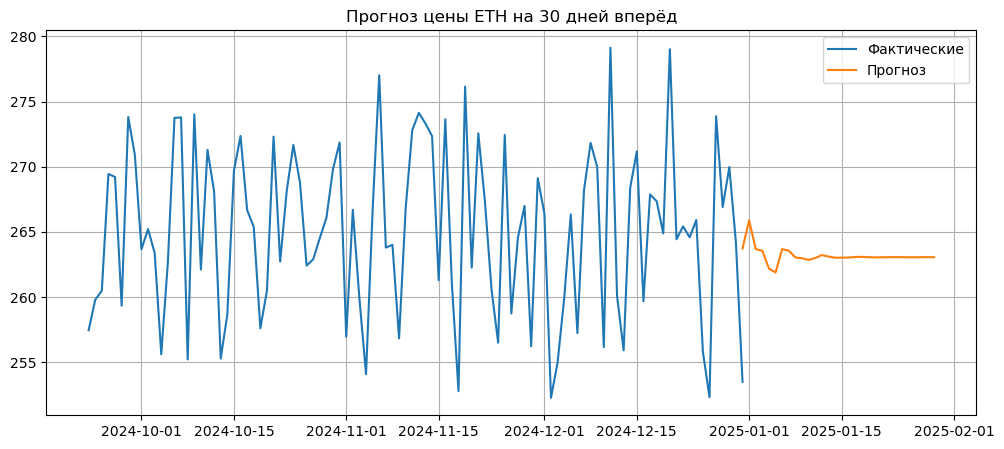

In [319]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены ETH на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show() 


In [320]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'ETH'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.81580705529705
R²: -0.43957263521715917

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
RMSE после тюнинга: 6.589794330172384
R² после тюнинга: -0.02336284224478158


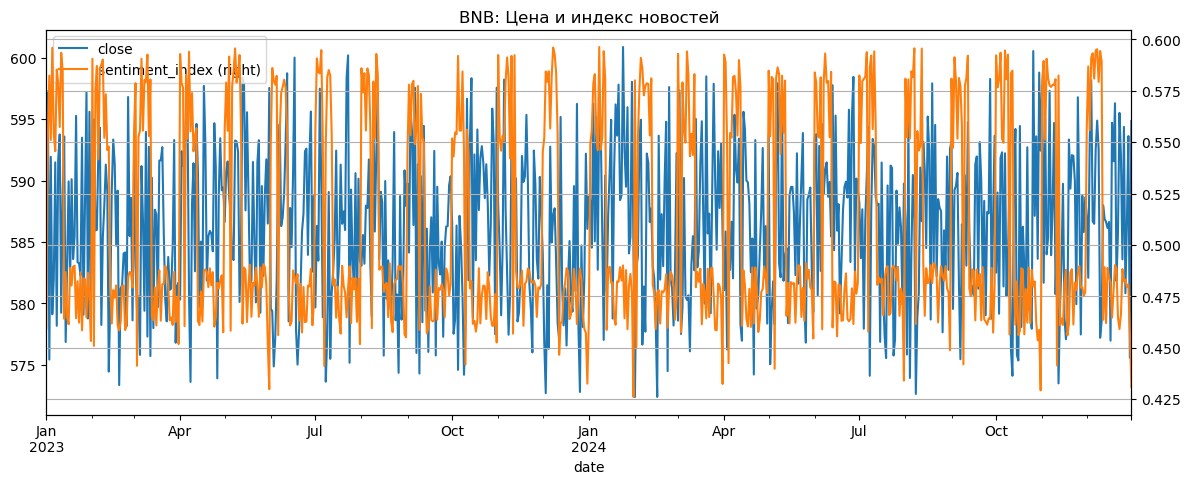

In [321]:
merged = prices[prices['symbol'] == 'BNB'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('BNB: Цена и индекс новостей')
plt.grid(True)
plt.show()

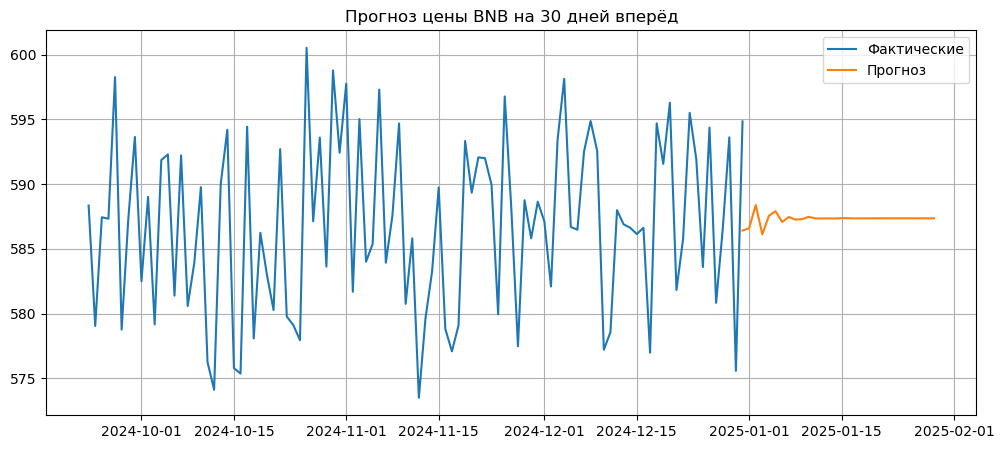

In [322]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены BNB на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()   

In [323]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'BNB'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.719912981709758
R²: -0.44571784437168516

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 150}
RMSE после тюнинга: 6.392023234621663
R² после тюнинга: 0.008859046539208881


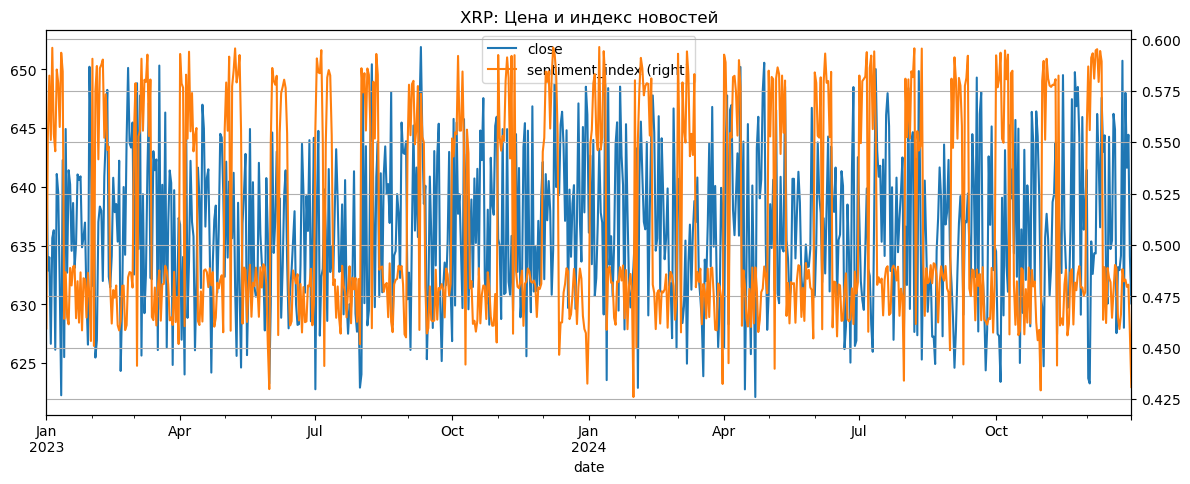

In [324]:
merged = prices[prices['symbol'] == 'XRP'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('XRP: Цена и индекс новостей')
plt.grid(True)
plt.show()

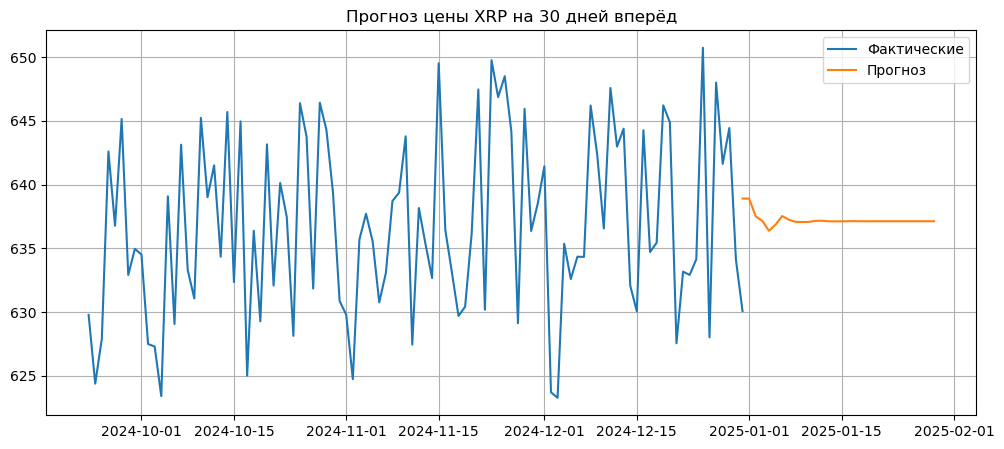

In [325]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены XRP на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()   

In [326]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'XRP'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 8.397727360945742
R²: -0.4525292966139758

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
RMSE после тюнинга: 6.917116722366123
R² после тюнинга: 0.014511484815092679


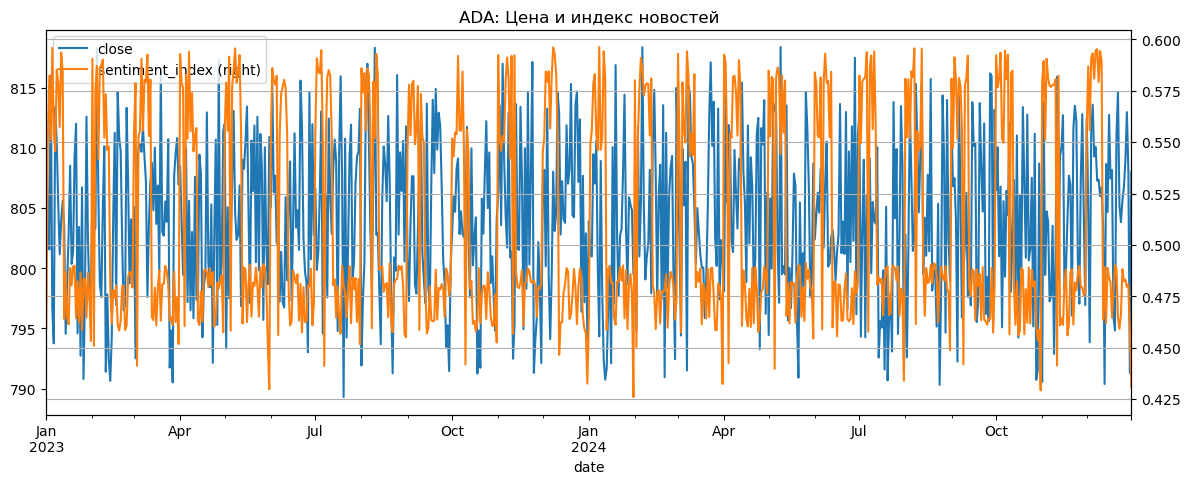

In [327]:
merged = prices[prices['symbol'] == 'ADA'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('ADA: Цена и индекс новостей')
plt.grid(True)
plt.show() 

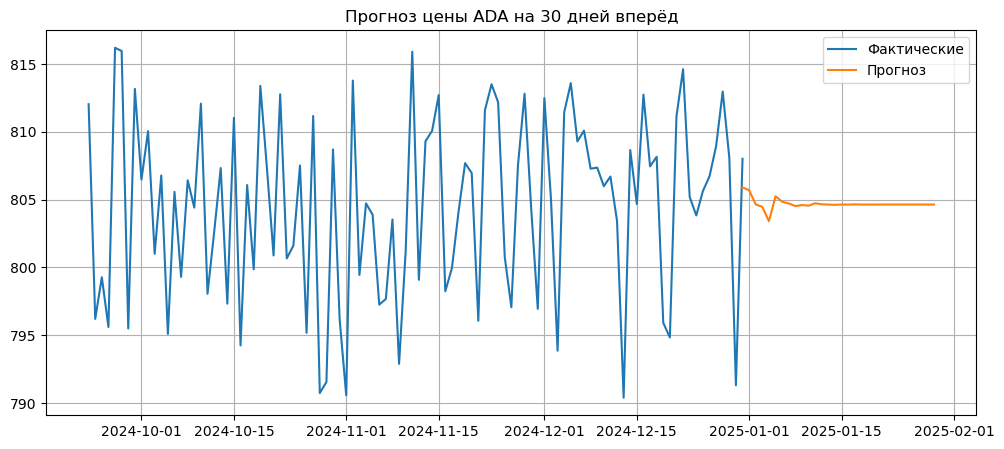

In [328]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены ADA на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show() 

In [329]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'ADA'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.874767269101769
R²: -0.3394947795677885

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
RMSE после тюнинга: 6.93245087870436
R² после тюнинга: -0.038099955202031355


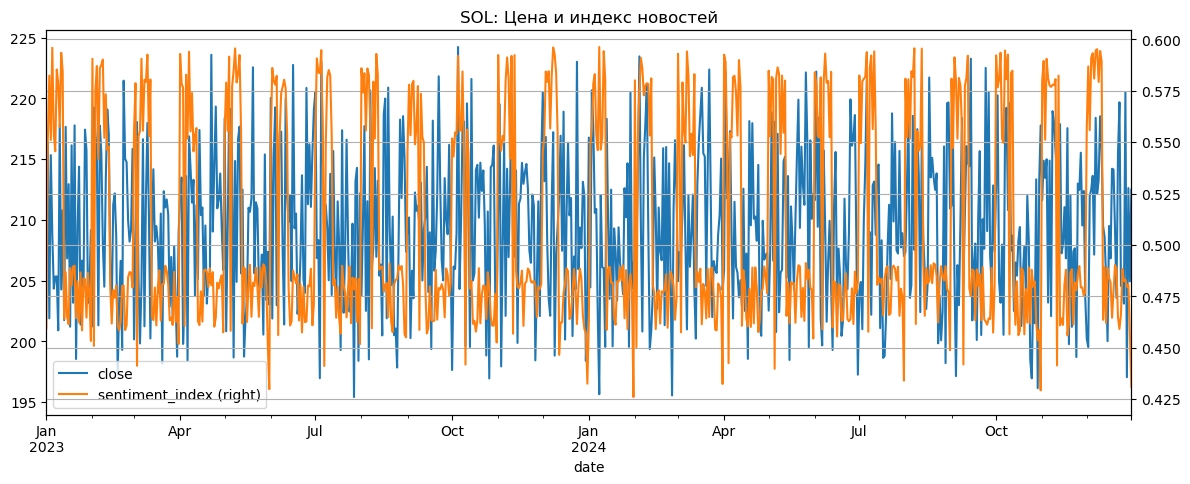

In [330]:
merged = prices[prices['symbol'] == 'SOL'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('SOL: Цена и индекс новостей')
plt.grid(True)
plt.show()  

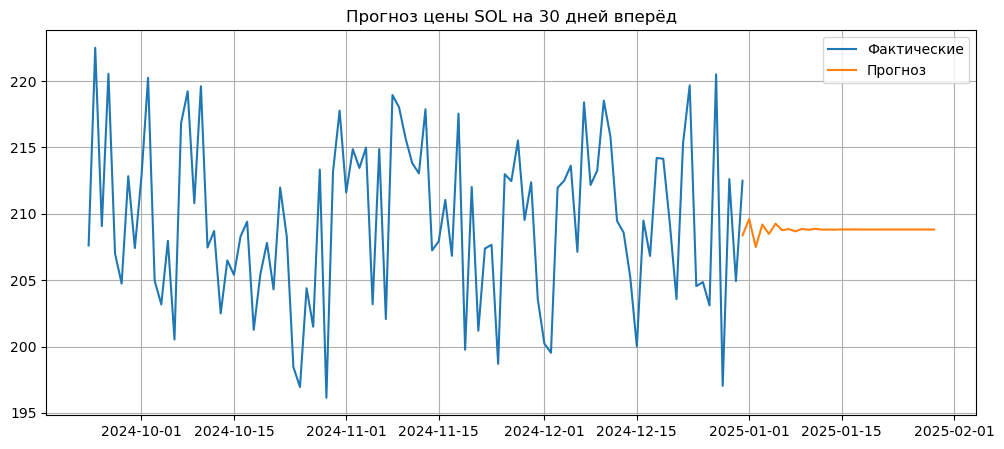

In [331]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены SOL на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show() 

In [332]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'SOL'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 6.981037272098032
R²: -0.20218284368511985

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
RMSE после тюнинга: 6.25597556218012
R² после тюнинга: 0.03457020123640364


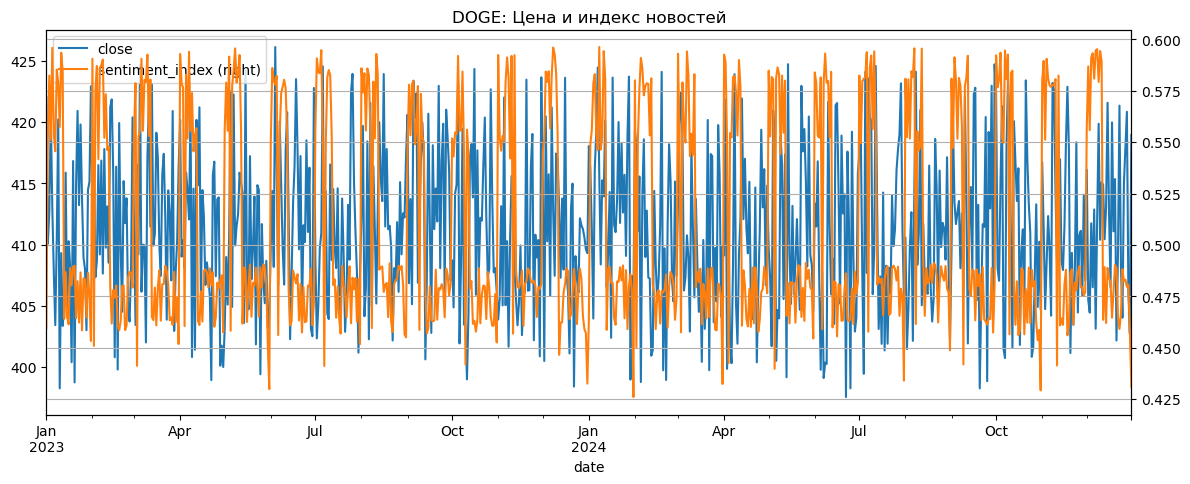

In [333]:
merged = prices[prices['symbol'] == 'DOGE'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('DOGE: Цена и индекс новостей')
plt.grid(True)
plt.show()

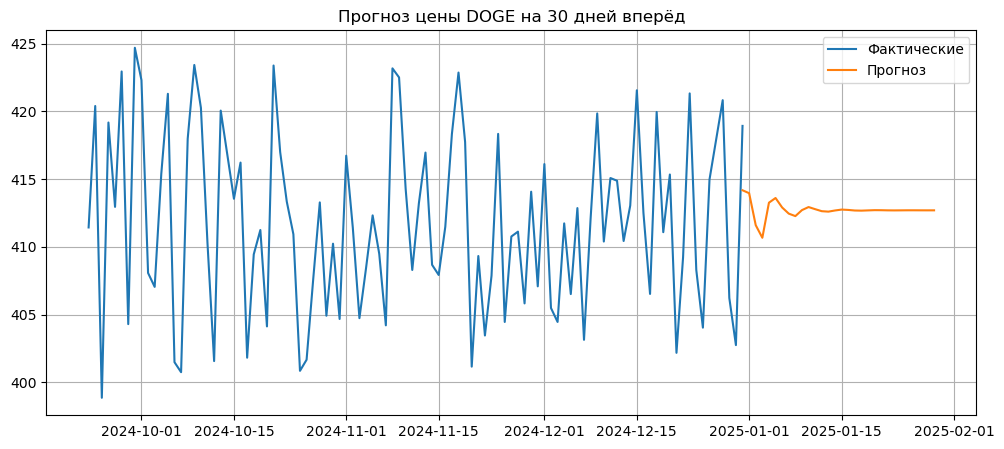

In [334]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены DOGE на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show() 

In [335]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'DOGE'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 8.017459454896825
R²: -0.5741825885243537

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
RMSE после тюнинга: 6.470351177067755
R² после тюнинга: -0.025267674893923786


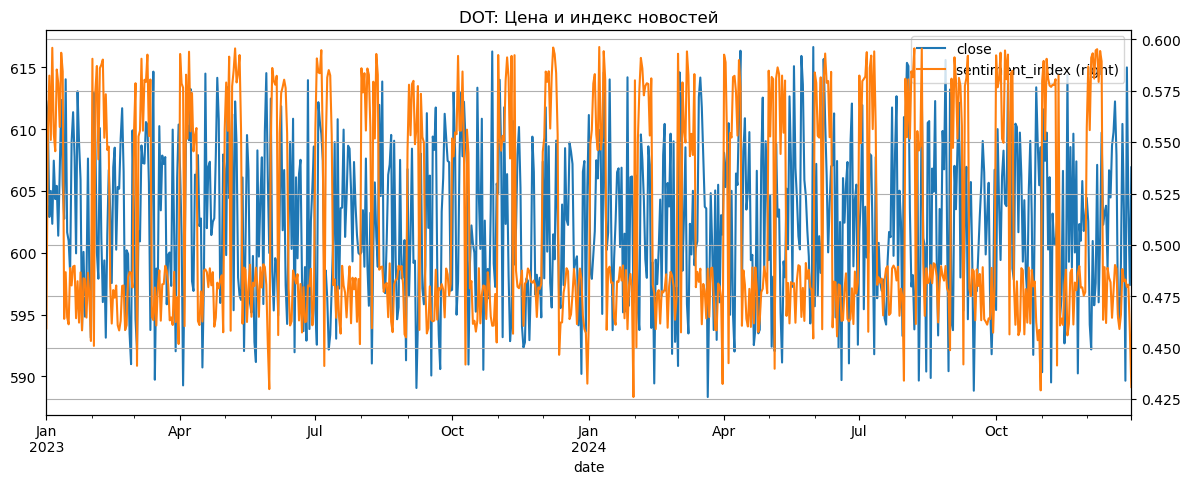

In [336]:
merged = prices[prices['symbol'] == 'DOT'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('DOT: Цена и индекс новостей')
plt.grid(True)
plt.show() 

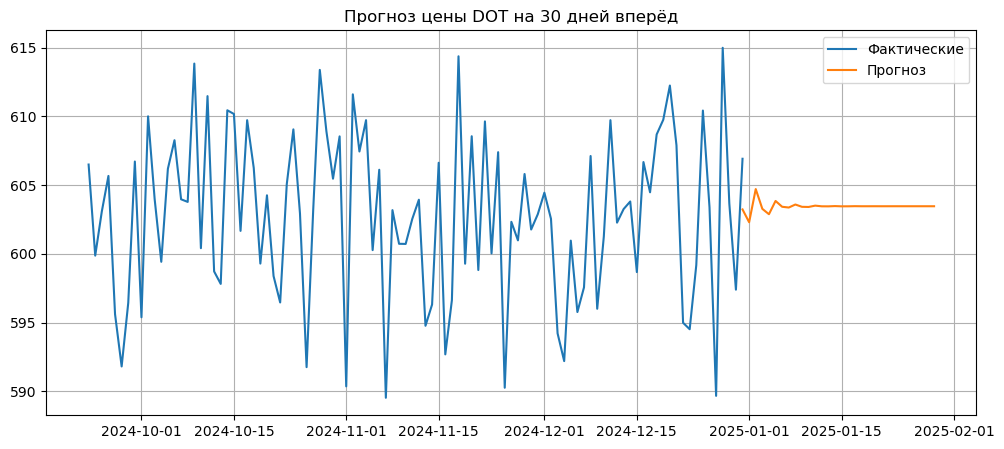

In [337]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены DOT на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show() 

In [338]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'DOT'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.868892352806222
R²: -0.4927951369487309

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
RMSE после тюнинга: 6.537124277555146
R² после тюнинга: -0.03025916391327277


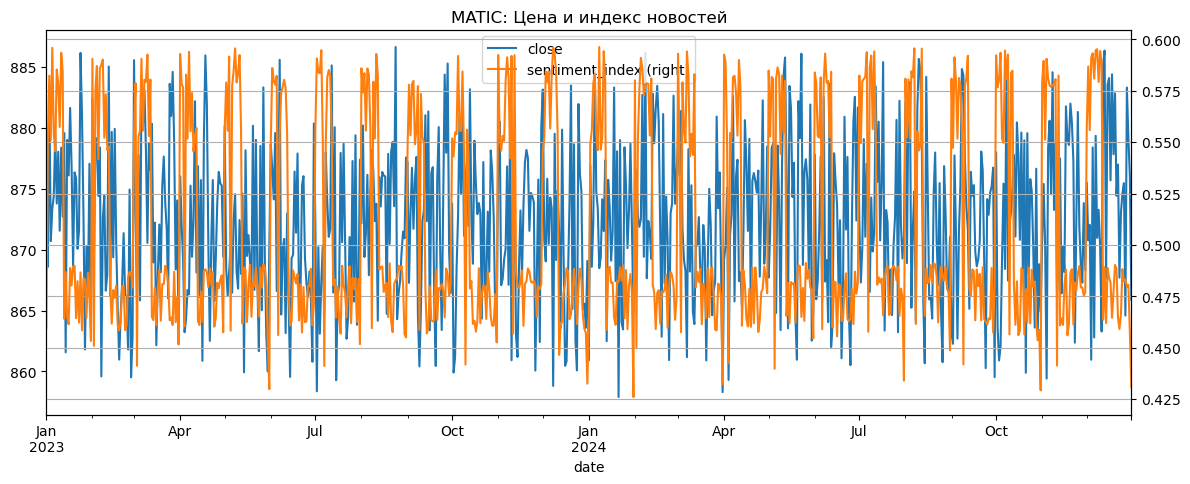

In [339]:
merged = prices[prices['symbol'] == 'MATIC'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('MATIC: Цена и индекс новостей')
plt.grid(True)
plt.show() 

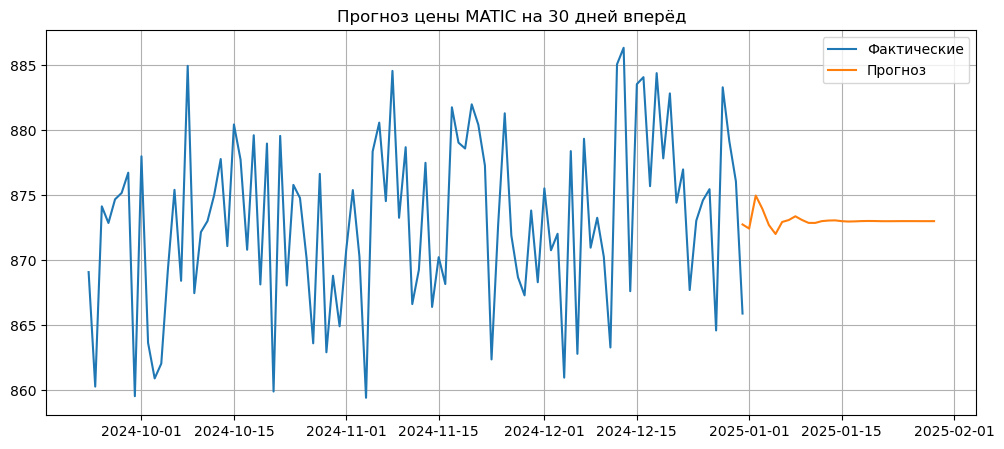

In [340]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены MATIC на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()

In [341]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'MATIC'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.853241292666831
R²: -0.3532435631665798

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
RMSE после тюнинга: 6.7403230464700155
R² после тюнинга: 0.0031277414407475668


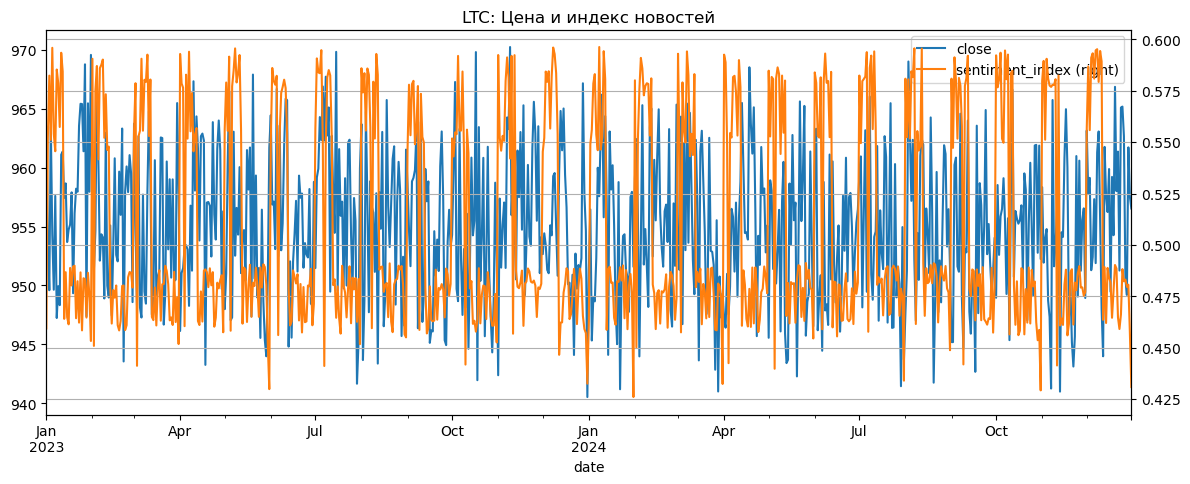

In [342]:
merged = prices[prices['symbol'] == 'LTC'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('LTC: Цена и индекс новостей')
plt.grid(True)
plt.show() 

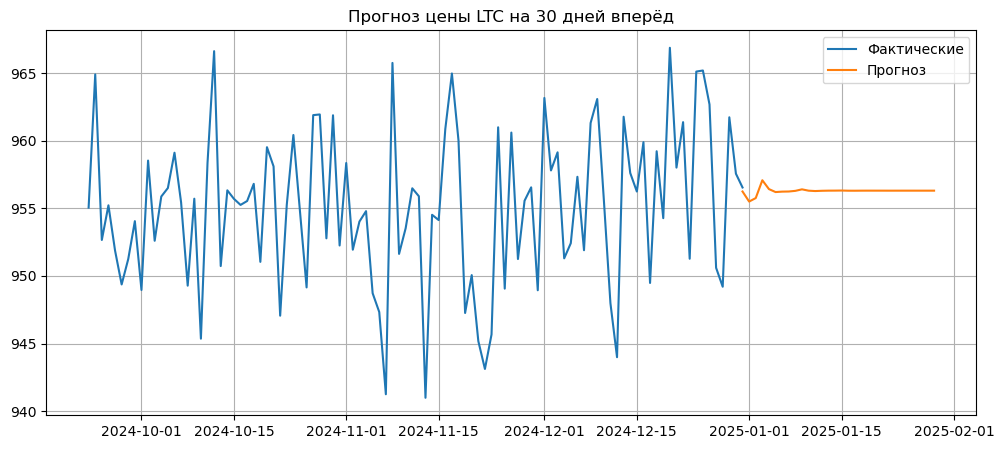

In [343]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены LTC на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()

In [344]:
# Подготовка данных
btc_data = prices[prices['symbol'] == 'LTC'].merge(daily_news, on='date', how='left').fillna(method='ffill')
btc_data.set_index('date', inplace=True)

X = btc_data[['sentiment_index']]
y = btc_data['close']

# Делим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Базовая модель
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("Базовая модель:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R²:", r2_score(y_test, y_pred_base))

# Кросс-валидация + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nЛучшая модель (после GridSearch):")
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("RMSE после тюнинга:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R² после тюнинга:", r2_score(y_test, y_pred_best))



Базовая модель:
RMSE: 7.589304069435454
R²: -0.6287004417420987

Лучшая модель (после GridSearch):
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
RMSE после тюнинга: 5.980054922732964
R² после тюнинга: -0.011224662016510623


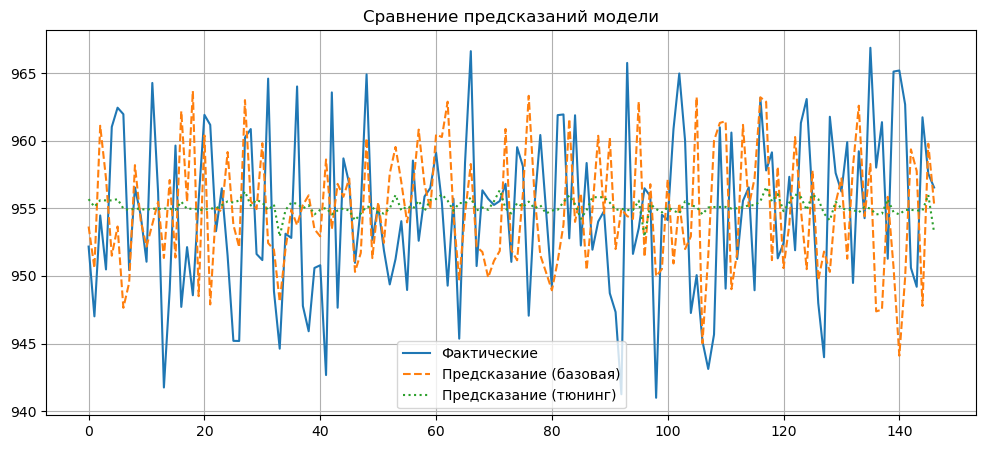

In [345]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Фактические')
plt.plot(y_pred_base, label='Предсказание (базовая)', linestyle='--')
plt.plot(y_pred_best, label='Предсказание (тюнинг)', linestyle=':')
plt.legend()
plt.title('Сравнение предсказаний модели')
plt.grid(True)
plt.show()
